<a href="https://colab.research.google.com/github/Jorgecuenca1/Tps_ProcesamientoLenguajeNatural/blob/main/clase4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [46]:
!pip install beautifulsoup4
!pip install requests
!pip install tensorflow
!pip install keras
!pip install nltk


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [47]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
import requests
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

nltk.download('punkt')
nltk.download('stopwords')

url = "https://www.gutenberg.org/about/background/history_and_philosophy.html#the-beginning-of-the-gutenberg-philosophy"
response = requests.get(url)

soup = BeautifulSoup(response.text, 'html.parser')

# Encuentra todo el texto en la página
text = soup.get_text()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [48]:
print(text)





History and Philosophy | Project Gutenberg



























Menu▾



About
          ▾

▾


About Project Gutenberg
Collection Development
Contact Us
History & Philosophy
Permissions & License
Privacy Policy
Terms of Use



Search and Browse
      	  ▾

▾


Book Search
Bookshelves
Frequently Downloaded
Offline Catalogs



Help
          ▾

▾


All help topics →
Copyright How-To
Errata, Fixes and Bug Reports
File Formats
Frequently Asked Questions
Policies →
Public Domain eBook Submission
Submitting Your Own Work
Tablets, Phones and eReaders
The Attic →


Donate










Donation







The History and Philosophy of Project Gutenberg, by Michael Hart
Â© August 1992

Contents

The Beginning
The Beginning of the Gutenberg Philosophy
The Project Gutenberg Philosophy (continued)
The Project Gutenberg Philosophy (continued)
The Project Gutenberg Philosophy (continued, 2)
The Selection of Project Gutenberg Etexts


The Beginning
Project Gutenberg began in 1971 when Michael Hart

### 1 - Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [49]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from keras.utils import pad_sequences # se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 4

In [50]:
tokens = text_to_word_sequence(text) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

['history',
 'and',
 'philosophy',
 'project',
 'gutenberg',
 'menu▾',
 'about',
 '▾',
 '▾',
 'about',
 'project',
 'gutenberg',
 'collection',
 'development',
 'contact',
 'us',
 'history',
 'philosophy',
 'permissions',
 'license',
 'privacy',
 'policy',
 'terms',
 'of',
 'use',
 'search',
 'and',
 'browse',
 '▾',
 '▾',
 'book',
 'search',
 'bookshelves',
 'frequently',
 'downloaded',
 'offline',
 'catalogs',
 'help',
 '▾',
 '▾',
 'all',
 'help',
 'topics',
 '→',
 'copyright',
 'how',
 'to',
 'errata',
 'fixes',
 'and',
 'bug',
 'reports',
 'file',
 'formats',
 'frequently',
 'asked',
 'questions',
 'policies',
 '→',
 'public',
 'domain',
 'ebook',
 'submission',
 'submitting',
 'your',
 'own',
 'work',
 'tablets',
 'phones',
 'and',
 'ereaders',
 'the',
 'attic',
 '→',
 'donate',
 'donation',
 'the',
 'history',
 'and',
 'philosophy',
 'of',
 'project',
 'gutenberg',
 'by',
 'michael',
 'hart',
 'â©',
 'august',
 '1992',
 'contents',
 'the',
 'beginning',
 'the',
 'beginning',
 'of'

1.1 - Transformar las oraciones en secuencias (tokens) de palabras

In [51]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [52]:
# Demos un vistazo
sentence_tokens[:2]

[['yesterday', 'all', 'my', 'troubles', 'seemed', 'so', 'far', 'away'],
 ['now', 'it', 'looks', 'as', 'though', "they're", 'here', 'to', 'stay']]

In [53]:
# Código para hacer el desfasaje de las palabras
# según el train_len
text_sequences = []

for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [54]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences 

[['history', 'and', 'philosophy', 'project'],
 ['and', 'philosophy', 'project', 'gutenberg'],
 ['philosophy', 'project', 'gutenberg', 'menu▾'],
 ['project', 'gutenberg', 'menu▾', 'about'],
 ['gutenberg', 'menu▾', 'about', '▾'],
 ['menu▾', 'about', '▾', '▾'],
 ['about', '▾', '▾', 'about'],
 ['▾', '▾', 'about', 'project'],
 ['▾', 'about', 'project', 'gutenberg'],
 ['about', 'project', 'gutenberg', 'collection'],
 ['project', 'gutenberg', 'collection', 'development'],
 ['gutenberg', 'collection', 'development', 'contact'],
 ['collection', 'development', 'contact', 'us'],
 ['development', 'contact', 'us', 'history'],
 ['contact', 'us', 'history', 'philosophy'],
 ['us', 'history', 'philosophy', 'permissions'],
 ['history', 'philosophy', 'permissions', 'license'],
 ['philosophy', 'permissions', 'license', 'privacy'],
 ['permissions', 'license', 'privacy', 'policy'],
 ['license', 'privacy', 'policy', 'terms'],
 ['privacy', 'policy', 'terms', 'of'],
 ['policy', 'terms', 'of', 'use'],
 ['terms'

1.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [55]:
tok = Tokenizer() 

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado, esta sutileza nos dará un pequeño
# problema al momento de hacer la codificación OHE, pero es sencillo de resolver
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [56]:
# Ahora sequences tiene los números "ID", largo 4
sequences

[[216, 6, 40, 9],
 [6, 40, 9, 8],
 [40, 9, 8, 344],
 [9, 8, 344, 63],
 [8, 344, 63, 77],
 [344, 63, 77, 77],
 [63, 77, 77, 63],
 [77, 77, 63, 9],
 [77, 63, 9, 8],
 [63, 9, 8, 217],
 [9, 8, 217, 345],
 [8, 217, 345, 343],
 [217, 345, 343, 94],
 [345, 343, 94, 216],
 [343, 94, 216, 40],
 [94, 216, 40, 346],
 [216, 40, 346, 347],
 [40, 346, 347, 218],
 [346, 347, 218, 219],
 [347, 218, 219, 220],
 [218, 219, 220, 2],
 [219, 220, 2, 54],
 [220, 2, 54, 34],
 [2, 54, 34, 6],
 [54, 34, 6, 348],
 [34, 6, 348, 77],
 [6, 348, 77, 77],
 [348, 77, 77, 41],
 [77, 77, 41, 34],
 [77, 41, 34, 349],
 [41, 34, 349, 155],
 [34, 349, 155, 350],
 [349, 155, 350, 351],
 [155, 350, 351, 352],
 [350, 351, 352, 156],
 [351, 352, 156, 77],
 [352, 156, 77, 77],
 [156, 77, 77, 32],
 [77, 77, 32, 156],
 [77, 32, 156, 353],
 [32, 156, 353, 157],
 [156, 353, 157, 78],
 [353, 157, 78, 70],
 [157, 78, 70, 3],
 [78, 70, 3, 354],
 [70, 3, 354, 355],
 [3, 354, 355, 6],
 [354, 355, 6, 356],
 [355, 6, 356, 357],
 [6, 356, 

In [57]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

2867


In [58]:
# Cantidad de veces que aparece cada palabra
print(len(tok.word_counts))

812


In [59]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'the': 1, 'of': 2, 'to': 3, 'a': 4, 'in': 5, 'and': 6, 'we': 7, 'gutenberg': 8, 'project': 9, 'be': 10, 'that': 11, 'is': 12, 'this': 13, 'for': 14, 'have': 15, 'â\x80¦': 16, 'are': 17, 'as': 18, 'etexts': 19, 'it': 20, 'not': 21, 'on': 22, 'can': 23, 'so': 24, 'an': 25, 'they': 26, 'our': 27, 'with': 28, 'was': 29, 'do': 30, 'you': 31, 'all': 32, 'will': 33, 'search': 34, 'any': 35, 'or': 36, 'vanilla': 37, 'etext': 38, 'plain': 39, 'philosophy': 40, 'book': 41, 'public': 42, 'other': 43, 'has': 44, 'one': 45, 'should': 46, 'by': 47, 'time': 48, 'at': 49, 'would': 50, 'them': 51, 'ascii': 52, 'files': 53, 'use': 54, 'when': 55, 'computer': 56, 'from': 57, 'general': 58, 'years': 59, '000': 60, 'only': 61, 'however': 62, 'about': 63, 'â\x80\x9d': 64, 'into': 65, 'available': 66, 'audience': 67, 'disk': 68, 'program': 69, 'how': 70, 'domain': 71, 'what': 72, 'could': 73, 'then': 74, 'same': 75, 'read': 76, '▾': 77, 'copyright': 78, 'continued': 79, '100': 80, 'there': 81, 'more': 82, '

In [60]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'and': 209, 'history': 9, 'philosophy': 51, 'project': 144, 'gutenberg': 152, 'menu▾': 4, 'about': 31, '▾': 15, 'collection': 8, 'development': 4, 'contact': 7, 'us': 20, 'permissions': 4, 'license': 4, 'privacy': 8, 'policy': 8, 'terms': 8, 'of': 367, 'use': 40, 'search': 52, 'browse': 4, 'book': 48, 'bookshelves': 4, 'frequently': 12, 'downloaded': 4, 'offline': 4, 'catalogs': 4, 'help': 12, 'all': 56, 'topics': 4, '→': 12, 'copyright': 24, 'how': 28, 'to': 323, 'errata': 4, 'fixes': 4, 'bug': 4, 'reports': 4, 'file': 12, 'formats': 20, 'asked': 12, 'questions': 4, 'policies': 4, 'public': 48, 'domain': 28, 'ebook': 4, 'submission': 4, 'submitting': 4, 'your': 20, 'own': 4, 'work': 20, 'tablets': 4, 'phones': 4, 'ereaders': 4, 'the': 681, 'attic': 4, 'donate': 4, 'donation': 4, 'by': 44, 'michael': 20, 'hart': 12, 'â©': 4, 'august': 4, '1992': 4, 'contents': 4, 'beginning': 14, 'continued': 24, '2': 8, 'selection': 8, 'etexts': 84, 'began': 4, 'in': 242, '

### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [61]:
# Vistazo a las primeras filas
df.loc[:15,0]

0         Yesterday, all my troubles seemed so far away
1           Now it looks as though they're here to stay
2     Oh, I believe in yesterday Suddenly, I'm not h...
3                     There's a shadow hanging over me.
4     Oh, yesterday came suddenly Why she had to go ...
5     I said something wrong, now I long for yesterd...
6                       Now I need a place to hide away
7     Oh, I believe in yesterday Why she had to go I...
8     I said something wrong, now I long for yesterd...
9                       Now I need a place to hide away
10                           Oh, I believe in yesterday
11    Mm mm mm mm mm mm mm When I find myself in tim...
12                  Speaking words of wisdom, let it be
13    And in my hour of darkness she is standing rig...
14                  Speaking words of wisdom, let it be
15           Let it be, let it be, let it be, let it be
Name: 0, dtype: object

In [62]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

'Yesterday, all my troubles seemed so far away Now it looks as though they\'re here to stay Oh, I believe in yesterday Suddenly, I\'m not half the man I used to be There\'s a shadow hanging over me. Oh, yesterday came suddenly Why she had to go I don\'t know she wouldn\'t say I said something wrong, now I long for yesterday Yesterday, love was such an easy game to play Now I need a place to hide away Oh, I believe in yesterday Why she had to go I don\'t know she wouldn\'t say I said something wrong, now I long for yesterday Yesterday, love was such an easy game to play Now I need a place to hide away Oh, I believe in yesterday Mm mm mm mm mm mm mm When I find myself in times of trouble, Mother Mary comes to me Speaking words of wisdom, let it be And in my hour of darkness she is standing right in front of me Speaking words of wisdom, let it be Let it be, let it be, let it be, let it be Whisper words of wisdom, let it be And when the broken hearted people living in the world agree There

In [63]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['yesterday',
 'all',
 'my',
 'troubles',
 'seemed',
 'so',
 'far',
 'away',
 'now',
 'it',
 'looks',
 'as',
 'though',
 "they're",
 'here',
 'to',
 'stay',
 'oh',
 'i',
 'believe']

In [64]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 14387


In [65]:
# Código para hacer el desfasaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [66]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['yesterday', 'all', 'my', 'troubles'],
 ['all', 'my', 'troubles', 'seemed'],
 ['my', 'troubles', 'seemed', 'so'],
 ['troubles', 'seemed', 'so', 'far'],
 ['seemed', 'so', 'far', 'away'],
 ['so', 'far', 'away', 'now'],
 ['far', 'away', 'now', 'it'],
 ['away', 'now', 'it', 'looks'],
 ['now', 'it', 'looks', 'as'],
 ['it', 'looks', 'as', 'though'],
 ['looks', 'as', 'though', "they're"],
 ['as', 'though', "they're", 'here'],
 ['though', "they're", 'here', 'to'],
 ["they're", 'here', 'to', 'stay'],
 ['here', 'to', 'stay', 'oh'],
 ['to', 'stay', 'oh', 'i'],
 ['stay', 'oh', 'i', 'believe'],
 ['oh', 'i', 'believe', 'in'],
 ['i', 'believe', 'in', 'yesterday'],
 ['believe', 'in', 'yesterday', 'suddenly']]

In [67]:
# Proceso de tokenización
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[216, 10, 12, 907],
 [10, 12, 907, 908],
 [12, 907, 908, 42],
 [907, 908, 42, 909],
 [908, 42, 909, 121],
 [42, 909, 121, 22],
 [909, 121, 22, 13],
 [121, 22, 13, 638],
 [22, 13, 638, 91],
 [13, 638, 91, 217],
 [638, 91, 217, 349],
 [91, 217, 349, 79],
 [217, 349, 79, 4],
 [349, 79, 4, 314],
 [79, 4, 314, 23],
 [4, 314, 23, 2],
 [314, 23, 2, 160],
 [23, 2, 160, 9],
 [2, 160, 9, 216],
 [160, 9, 216, 520]]

In [68]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 14383


### 3 - Input y target

In [69]:
# Con numpy es muy fácil realizar el slicing de vectores
ex = np.array([[1,2,3,4],[5,6,7,8]])
ex

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [70]:
# Con numpy es muy fácil realizar el slicing de vectores
print("Dimension:", ex.shape)
print("Todos los elementos:", ex)
print("Todos los elementos menos el último:", ex[:, :-1])

Dimension: (2, 4)
Todos los elementos: [[1 2 3 4]
 [5 6 7 8]]
Todos los elementos menos el último: [[1 2 3]
 [5 6 7]]


In [71]:
input = ex[:,:-1] # todos los rows, menos la ultima col
target = ex[:, -1] # última col de cada row

print("Input:", input)
print("Target:", target)

Input: [[1 2 3]
 [5 6 7]]
Target: [4 8]


In [72]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(14383, 3)
(14383,)


In [73]:
# Palabras del vocabulario
tok.index_word

{1: 'you',
 2: 'i',
 3: 'the',
 4: 'to',
 5: 'and',
 6: 'love',
 7: 'a',
 8: 'me',
 9: 'in',
 10: 'all',
 11: 'nah',
 12: 'my',
 13: 'it',
 14: 'know',
 15: 'be',
 16: 'that',
 17: 'of',
 18: 'on',
 19: 'she',
 20: 'is',
 21: 'say',
 22: 'now',
 23: 'oh',
 24: 'yeah',
 25: 'your',
 26: 'get',
 27: "don't",
 28: 'back',
 29: 'let',
 30: 'with',
 31: 'her',
 32: 'can',
 33: "it's",
 34: 'do',
 35: "i'm",
 36: 'when',
 37: 'come',
 38: 'will',
 39: 'he',
 40: 'but',
 41: 'for',
 42: 'so',
 43: 'need',
 44: 'there',
 45: 'like',
 46: 'together',
 47: 'no',
 48: "i'll",
 49: 'see',
 50: 'was',
 51: 'never',
 52: 'we',
 53: 'down',
 54: 'way',
 55: 'if',
 56: 'want',
 57: 'out',
 58: 'hey',
 59: 'one',
 60: 'got',
 61: 'go',
 62: 'well',
 63: "can't",
 64: 'girl',
 65: 'good',
 66: 'his',
 67: 'sun',
 68: 'they',
 69: 'home',
 70: 'hello',
 71: 'day',
 72: 'are',
 73: 'ah',
 74: 'right',
 75: 'little',
 76: 'at',
 77: 'from',
 78: 'man',
 79: 'here',
 80: 'help',
 81: 'gonna',
 82: 'have',
 

In [74]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

1628

In [89]:
# Transformar los datos a oneHotEncoding
y_data = to_categorical(y_data_int, num_classes=1629)

In [76]:
# En el caso anterior explota porque y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [77]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(14383, 1628)

### 4 - Entrenar el modelo

In [78]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [79]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

1628

In [80]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 5)              8145      
                                                                 
 lstm (LSTM)                 (None, 3, 64)             17920     
                                                                 
 dropout (Dropout)           (None, 3, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1628)              53724     
                                                                 
Total params: 114,893
Trainable params: 114,893
Non-trai

In [81]:
hist = model.fit(x_data, y_data, epochs=50, validation_split=0.2)

Epoch 1/50
360/360 [==============================] - 20s 25ms/step - loss: 6.1364 - accuracy: 0.0477 - val_loss: 6.5269 - val_accuracy: 0.0400
Epoch 2/50
360/360 [==============================] - 3s 9ms/step - loss: 5.7457 - accuracy: 0.0501 - val_loss: 6.6650 - val_accuracy: 0.0400
Epoch 3/50
360/360 [==============================] - 3s 9ms/step - loss: 5.6974 - accuracy: 0.0511 - val_loss: 6.7541 - val_accuracy: 0.0400
Epoch 4/50
360/360 [==============================] - 4s 10ms/step - loss: 5.6302 - accuracy: 0.0630 - val_loss: 6.7707 - val_accuracy: 0.0389
Epoch 5/50
360/360 [==============================] - 3s 9ms/step - loss: 5.5190 - accuracy: 0.0668 - val_loss: 6.8727 - val_accuracy: 0.0466
Epoch 6/50
360/360 [==============================] - 3s 8ms/step - loss: 5.4019 - accuracy: 0.0725 - val_loss: 6.9486 - val_accuracy: 0.0528
Epoch 7/50
360/360 [==============================] - 3s 8ms/step - loss: 5.3077 - accuracy: 0.0761 - val_loss: 7.1334 - val_accuracy: 0.0542
Epo

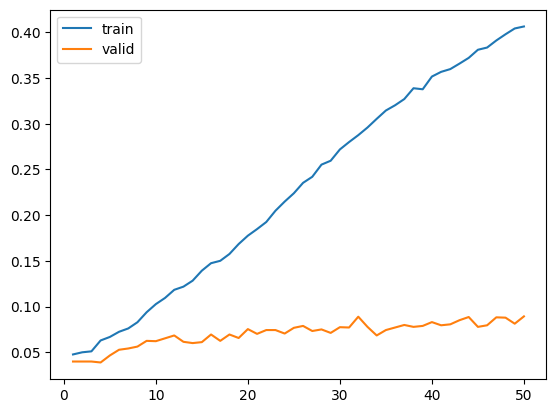

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Predicción de próxima palabra

In [83]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [84]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 84.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.1/288.1 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.8 MB/s eta 0:

In [85]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

<ipython-input-85-2a8fe09160a6>:24: UserWarning: `layout` parameter is deprecated, and it has no effect
  iface = gr.Interface(


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 18ms/step
Keyboard interruption in main thread... closing server.


### 6 - Generación de secuencias nuevas

In [91]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [92]:
input_text=' Project Gutenberg Etexts are made available in what has become known as “Plain Vanilla ASCII,” meaning the low set of the American Standard Code for Information Interchange: i.e., the same kind of character you read on\'t'

generate_seq(model, tok, input_text, max_length=3, n_words=2)

1/1 [==============================] - 0s 19ms/step


" Project Gutenberg Etexts are made available in what has become known as “Plain Vanilla ASCII,” meaning the low set of the American Standard Code for Information Interchange: i.e., the same kind of character you read on't love the"

### 7 - Conclusiones
El modelo entrenado tuvo un muy mail desempeño en el entrenamiento además de overfitting. Cuestiones que podrían mejorarse:
- Agregar más capas o neuronaes
- Incrementar la cantidad de épocas
- Agregar BRNN

Es importante destacar que en este ejemplo estamos entrenando nuestro propios Embeddings, y para ello se requiere mucha data. En los ejemplos que realizaremos de aquí en más utilizaremos más datos, embeddings pre-enternados o modelos pre-entrenados.